In [1]:
%reset -f

In [2]:
import os
import pandas as pd 
import numpy as np
from os.path import join as pjoin
import matplotlib as mpl
import seaborn as sns
import statsmodels.api as sm
import pingouin as pg
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")

In [3]:


np.set_printoptions(precision=3, suppress=True)


InputPath = r'E:\Modeling\MyProject_CLIP\Patients_Data\B_ROIlevel_ResetRDM\OCpatient_ResetRDM/'
ROIFolderName = 'WTPic_ROImask'
InputPath = InputPath + ROIFolderName + '/'

pat_wm = pd.read_csv(r"E:\Modeling\MyProject_CLIP\Patients_Data\Lesion_Chy\FA_leftVis_Lang_wm0.4_gp0.5_ip0.1.csv")
pd_behav = pd.read_excel(r"E:\Modeling\MyProject_CLIP\Patients_Data\Lesion_Chy\OCp_Corrected_Behav.xlsx")

del_list =[]
pat_wm = pat_wm.drop(pat_wm[pat_wm['Subject'].isin(del_list)].index)
pd_behav = pd_behav.drop(pd_behav[pd_behav['sub'].isin(del_list)].index)

totalLV = pd_behav['lesion_volume'].reset_index(drop=True)
visualLV = pd_behav['visual_lesion_volume']

In [4]:

raw_X = pat_wm.iloc[:,2:8]
indicator = raw_X.columns
scaler = StandardScaler()
y_scaler = StandardScaler()

In [13]:
clip = pd.read_csv(os.path.join(InputPath,'corrT_clip_res.csv'))
clip = clip.drop(clip[clip['SubID'].isin(del_list)].index)
moco = pd.read_csv(os.path.join(InputPath,'corrT_moco_avgpool.csv'))
moco = moco.drop(moco[moco['SubID'].isin(del_list)].index)
RN50 = pd.read_csv(os.path.join(InputPath,'corrT_res_avgpool.csv'))
RN50 = RN50.drop(RN50[RN50['SubID'].isin(del_list)].index)


# roi_name = ['Left_WTPic_Harvord_visual_2mm_binary','Right_WTPic_Harvord_visual_2mm_binary']
# Cortex_name = ['Left Visual Cortex','Right Visual Cortex']

roi_name = ['Left_WTPic_Harvord_visual_2mm_binary']
# indicator = ['leftAG']
indicator = ['leftAG','leftATL','leftIFG','leftIFGorb','leftMFG','leftpMTG']
Cortex_name = ['Left Visual Cortex']
Regression_results = pd.DataFrame()


for ind in indicator:
    for r,roi in enumerate(roi_name):
        clip_fish = clip[clip["roi_name"]==roi].reset_index(drop=True)
        clip_fish = clip_fish.rename(columns={'fishZ_r': 'clip_fishZ_r'})
        moco_fish = moco[moco["roi_name"]==roi].reset_index(drop=True)
        moco_fish = moco_fish.rename(columns={'fishZ_r': 'moco_fishZ_r'})
        RN50_fish = RN50[RN50["roi_name"]==roi].reset_index(drop=True)
        RN50_fish = RN50_fish.rename(columns={'fishZ_r': 'RN50_fishZ_r'})
        
        y = pat_wm[ind].reset_index(drop=True)

        X_resid = pd.concat([clip_fish['clip_fishZ_r'],moco_fish['moco_fishZ_r'],RN50_fish['RN50_fishZ_r'],totalLV],axis=1)
        X_resid_scaled = pd.DataFrame(scaler.fit_transform(X_resid),columns = ['clip_fishZ_r_resid','moco_fishZ_r_resid','RN50_fishZ_r_resid','totalLV'])
        
        y_resid_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))
        

        model = sm.OLS(y_resid_scaled, sm.add_constant(X_resid_scaled)).fit()
        conf = model.conf_int(alpha=0.05)



        new_row = pd.DataFrame({
            'ROI': [Cortex_name[r]],
            'Indicator': [ind],
            'r_squared': [model.rsquared],
            'adj_r^2': [model.rsquared_adj],
            'f_value': [model.fvalue],
            'f_pvalue': [model.f_pvalue],
            'const': [model.params['const']],
            'clip_coef': [model.params[1]],
            'clip_p': [model.pvalues[1]],
            'moco_coef': [model.params[2]],
            'moco_p': [model.pvalues[2]],
            'RN50_coef': [model.params[3]],
            'RN50_p': [model.pvalues[3]]
        })

        Regression_results = pd.concat([Regression_results, new_row], ignore_index=True)
        







C:\Users\DELL\AppData\Local\Temp\ipykernel_94472\583374234.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'clip_coef': [model.params[1]],
C:\Users\DELL\AppData\Local\Temp\ipykernel_94472\583374234.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'clip_p': [model.pvalues[1]],
C:\Users\DELL\AppData\Local\Temp\ipykernel_94472\583374234.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'moco_coef': [model.params[2]],
C:\Use

In [7]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     3.495
Date:                Sun, 30 Mar 2025   Prob (F-statistic):             0.0195
Time:                        13:44:36   Log-Likelihood:                -40.142
No. Observations:                  33   AIC:                             90.28
Df Residuals:                      28   BIC:                             97.77
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.908e-17      0.154  -1.24e-16      1.000      -0.316       0.316
clip_fishZ_r_resid     0.3788      0.166      2.288      0.030       0.040       0.718
moco_fishZ_r_resid    -0.5819      0.187     -3.118      0.004      -0.964      -0.200
RN50_fishZ_r_resid     0.3256      0.179      1.819      0.080      -0.041       0.692
totalLV               -0.3156      0.158     -1.998      0.056      -0.639       0.008
==============================================================================
Omnibus:                        1.282   Durbin-Watson:                   1.650
Prob(Omnibus):                  0.527   Jarque-Bera (JB):                1.152
Skew:                          -0.427   Prob(JB):                        0.562
Kurtosis:                       2.669   Cond. No.                         1.95
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
Regression_results.to_csv(r"C:\Users\39694\Desktop\Figure\Study2_lesion\RegressionModel\leftVis\Regression_standard_results_wp0.4_gp0.5_leftVis_change.csv",index=False)

In [ ]:
# Regression_results = pd.read_csv(r"C:\Users\39694\Desktop\Figure\Study2_lesion\RegressionModel\leftVis\Regression_standard_results_wp0.4_gp0.5_leftVis.csv") 
Regression_results = pd.read_excel(r"C:\Users\39694\Desktop\Figure\Study2_lesion\RegressionModel\leftVis\Regression_standard_results_wp0.4_gp0.5_leftVis.xlsx",sheet_name='leftLang')

## only R^2

C:\Users\DELL\AppData\Local\Temp\ipykernel_94472\3006719132.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Greys')


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\39694\\Desktop\\Figure\\Study2_lesion\\RegressionModel\\leftVis\\Regression_standard_results_go0.5_leftVis_leftLang_R2.png'

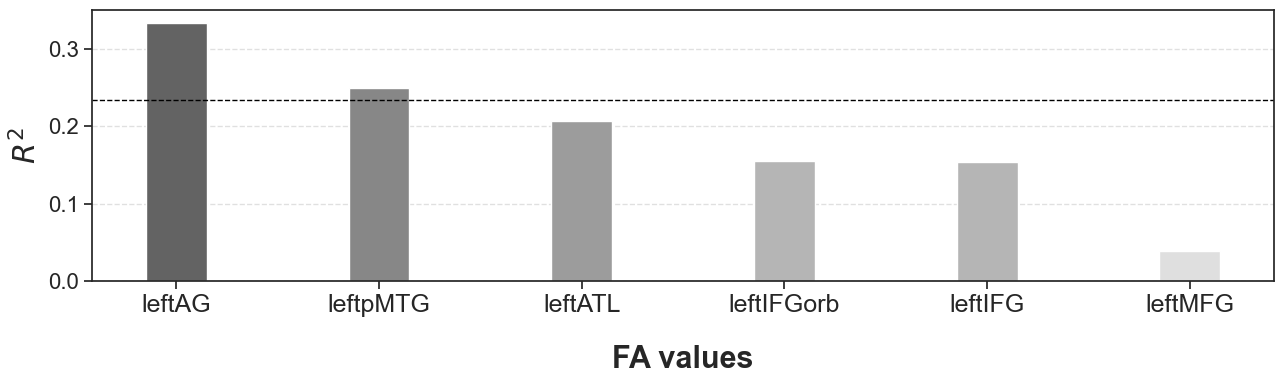

In [14]:
import matplotlib.pyplot as plt
import numpy as np



Regression_results = Regression_results.sort_values(by='r_squared', ascending=False)
indicators = Regression_results['Indicator'].unique()

# 计算每个组的x轴位置
bar_positions = []
for i in range(len(indicators)):
    bar_positions.append(i)  # 左半球位置


bar_positions = np.array(bar_positions)

# 准备绘图
fig,ax = plt.subplots(1,1,figsize=(13,4))


# 下图：绘制R_squared柱状图
import matplotlib.cm as cm
import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin=-0.1, vmax=max(Regression_results['r_squared'])+0.2)
cmap = cm.get_cmap('Greys')
colors = cmap(norm(Regression_results['r_squared']))

# 使用渐变灰色绘制R_squared柱状图
ax.bar(bar_positions, Regression_results['r_squared'], color=colors, width=0.3)
ax.axhline(y=0.233, color='black', linestyle='--', linewidth=1)

# 设置y轴标签和x轴刻度
ax.set_ylabel('$R^2$', fontdict={'size': 22,'weight':'bold'})
ax.set_xticks(bar_positions)



ax.grid(True, axis='y', linestyle='--', alpha=0.6)

ax.set_xlabel('FA values',fontdict={'size': 22,'weight':'bold'},labelpad=20)
ax.set_xticklabels(indicators, fontsize=18)

# 减少下方子图 Y 轴上刻度的密度
from matplotlib.ticker import MaxNLocator

ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
ax.tick_params(axis='y', labelsize=16)
# 调整布局和间距
plt.tight_layout()

plt.savefig(r"C:\Users\39694\Desktop\Figure\Study2_lesion\RegressionModel\leftVis\Regression_standard_results_go0.5_leftVis_leftLang_R2.png",dpi=400)
plt.show()


# Partial Correlation

# 双y轴绘图

In [16]:
# 最终成图版
# 设置全局字体和图形风格
from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines


mpl.rcParams['font.family'] = 'Arial'
indicator= ['FA_leftATL-leftAG']
# indicator= ['verbal_color_zscore']
ind_label = ['FA values of Vision-rightAG']


CortexLabel = ['Left Visual Cortex']
roi_name = ['Left_WTPic_Harvord_visual_2mm_binary']

clip_fish = pd.read_csv(os.path.join(InputPath,'pcorrT_clip_res_uniquePool.csv'))
moco_fish = pd.read_csv(os.path.join(InputPath,'pcorrT_mocoPool_unique.csv'))

for r,roi in enumerate(roi_name):

    for idx,ind in enumerate(indicator):

        Interest_var = pat_wm[ind].reset_index(drop=True)

        X = pd.concat([Interest_var,totalLV],axis=1)
        y_clip = clip_fish[clip_fish['roi_name']==roi]["fishZ_r"].reset_index(drop=True).rename('clip_fishZ_r')
        y_moco = moco_fish[moco_fish['roi_name']==roi]["fishZ_r"].reset_index(drop=True).rename('moco_fishZ_r')
        
        raw_data = pd.concat([X,y_clip,y_moco],axis=1)

        

        y_clip_resid = sm.OLS(y_clip, sm.add_constant(totalLV)).fit().resid
        y_moco_resid = sm.OLS(y_moco, sm.add_constant(totalLV)).fit().resid
        x_resid = sm.OLS(Interest_var, sm.add_constant(totalLV)).fit().resid
        

        plt.figure(figsize=(10,9))
        
        ax = sns.regplot(x=x_resid, y=y_clip_resid, scatter_kws={'s': 50, 'color': 'red','marker':'o'}, line_kws={"color": "red"}, ci=None)
        sns.regplot(x=x_resid, y=y_moco_resid, scatter_kws={'s': 50, 'color': 'blue','marker':'^'}, line_kws={"color": "blue"}, ci=None,ax=ax)



        corr_clip = pg.partial_corr(raw_data,x=ind, y='clip_fishZ_r', covar=['lesion_volume'], method='pearson',alternative='greater')
        corr_moco = pg.partial_corr(raw_data,x=ind, y='moco_fishZ_r', covar=['lesion_volume'], method='pearson',alternative='less')



        # Get axis limits to place text in the upper right corner
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        


        line1 = mlines.Line2D([], [], color='red', marker='o', markersize=8, label=rf'CLIP effect (cov RN50 & MoCo): $\rho={corr_clip["r"].values[0]:.2f}$, $p={corr_clip["p-val"].values[0]:.3f}$')
        line2 = mlines.Line2D([], [], color='blue', marker='o', markersize=8, label=rf'MoCo effect (cov CLIP & RN50): $\rho={corr_moco["r"].values[0]:.2f}$, $p={corr_moco["p-val"].values[0]:.3f}$')
        plt.legend(handles=[line1, line2], loc='upper right', fontsize=18,frameon=False)

        # Label the axes
        plt.ylabel(f'Fisher-Z transformed r value \n (cov total lesion volume)', fontdict={'size': 24,'weight':'bold'},labelpad=10)
        plt.xlabel(f'{ind_label[idx]}\n (cov total lesion volume)', fontdict={'size': 24,'weight':'bold'},labelpad=10)
        plt.title(CortexLabel[r], fontdict={'size': 28,'weight':'bold'})

        # Customize the grid
        plt.grid(True, which='both', color='lightgray', linestyle='-', linewidth=0.7,alpha=0.4)

        # Set limits for x and y axis for clarity
        plt.xlim(xlim[0] * 1.15, xlim[1] * 1.15)
        plt.ylim(ylim[0] * 1.15, ylim[1] * 1.15)
        plt.tick_params(axis='both',labelsize=18)

        plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=5))
        plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=5))
        # Show the plot
        plt.tight_layout()
        # plt.savefig(pjoin(r'C:\Users\39694\Desktop\Figure\Study2_lesion\RegressionModel\leftVis\Double_y_Des_MoCo_rightLang',roi +'_' +ind+'.png'))
        # plt.close()






KeyError: 'FA_leftATL-leftAG'

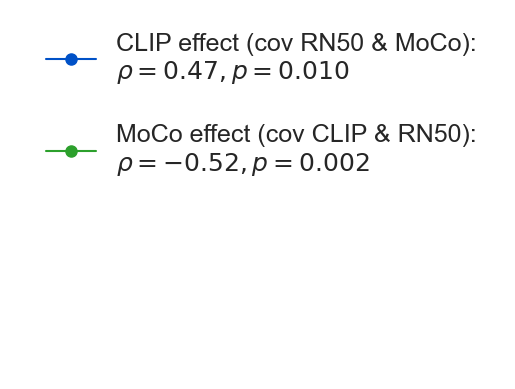

In [163]:
fig,ax = plt.subplots()
line1 = mlines.Line2D([], [], color='#0051C7', marker='o', markersize=8, label='CLIP effect (cov RN50 & MoCo): \n$\\rho={0.47},p={0.010}$')
line2 = mlines.Line2D([], [], color='#2ca02c', marker='o', markersize=8, label='MoCo effect (cov CLIP & RN50): \n$\\rho={-0.52},p={0.002}$')
plt.legend(handles=[line1, line2], loc='upper right', fontsize=18,frameon=False,labelspacing=1.5)
ax.axis('off')
plt.savefig(pjoin(r'C:\Users\39694\Desktop\Figure\Study2_lesion\RegressionModel\legend.png'),dpi=600)

# MAWS

# 单y轴绘图

## CLIP Specific effet

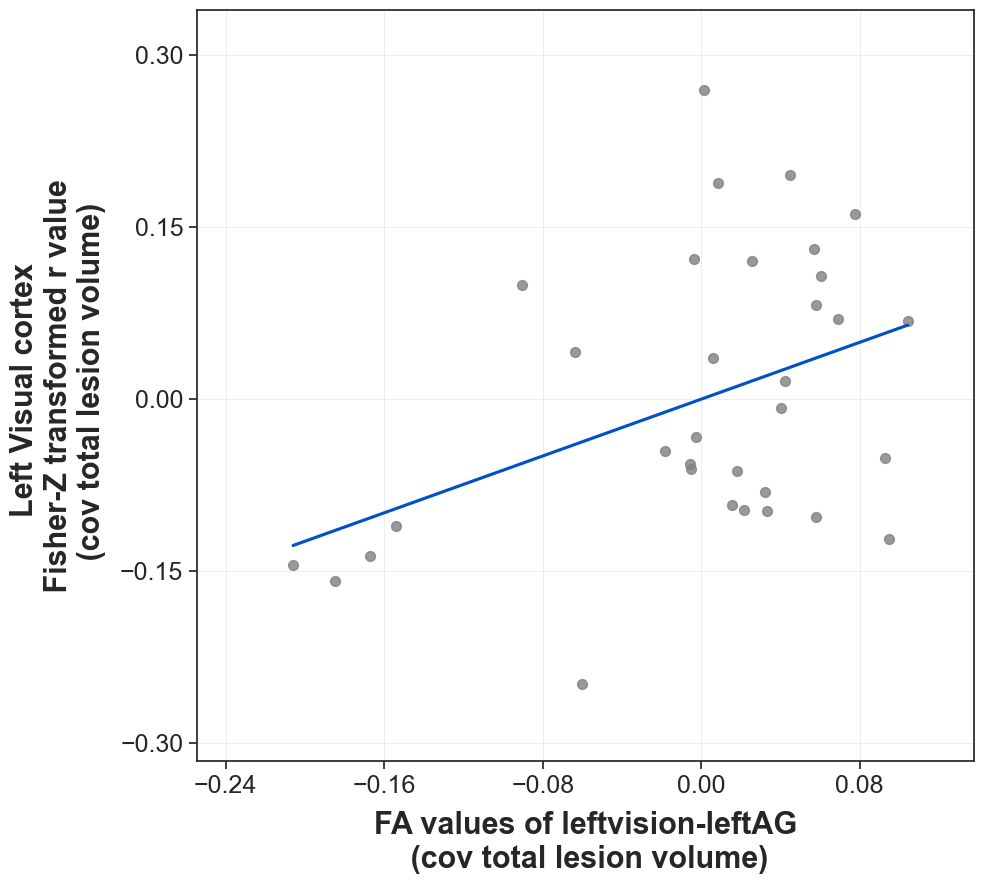

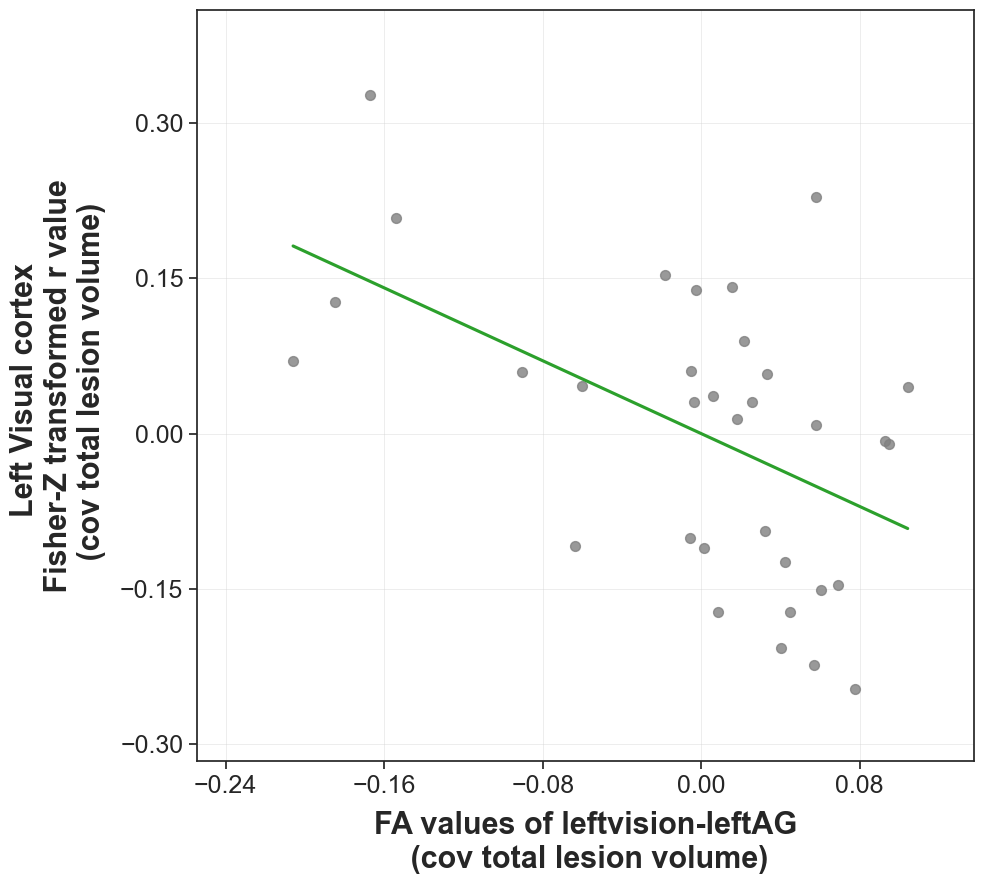

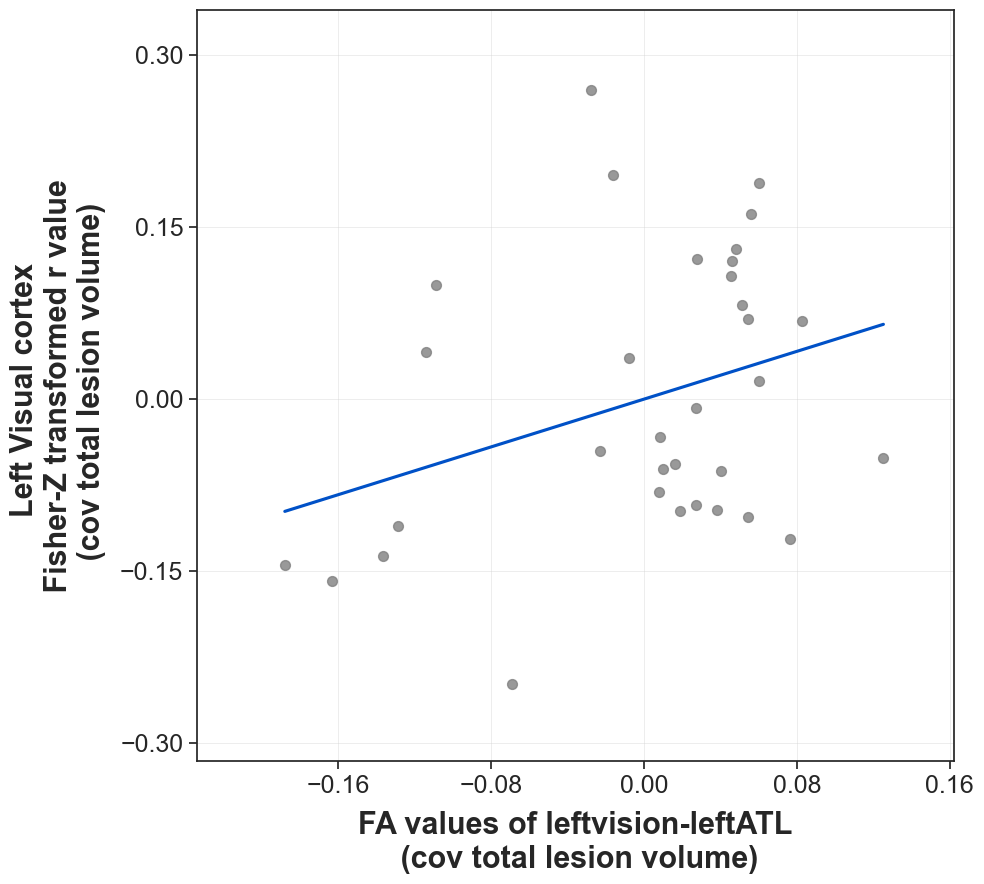

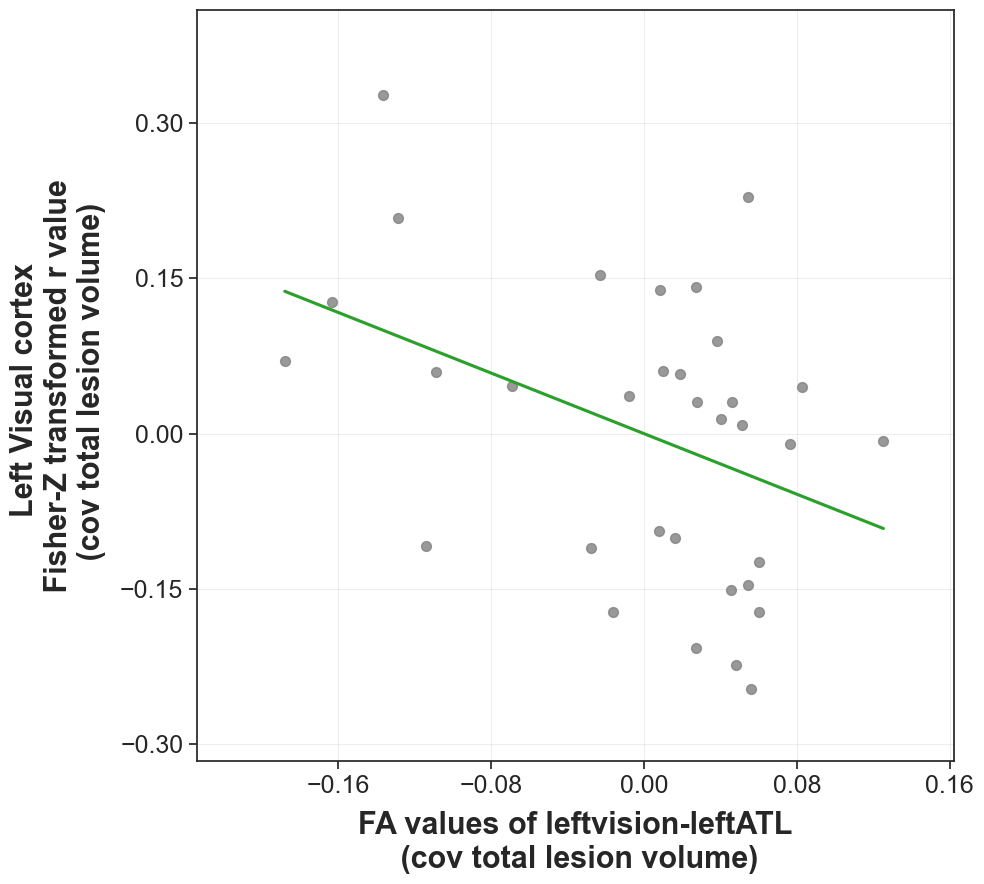

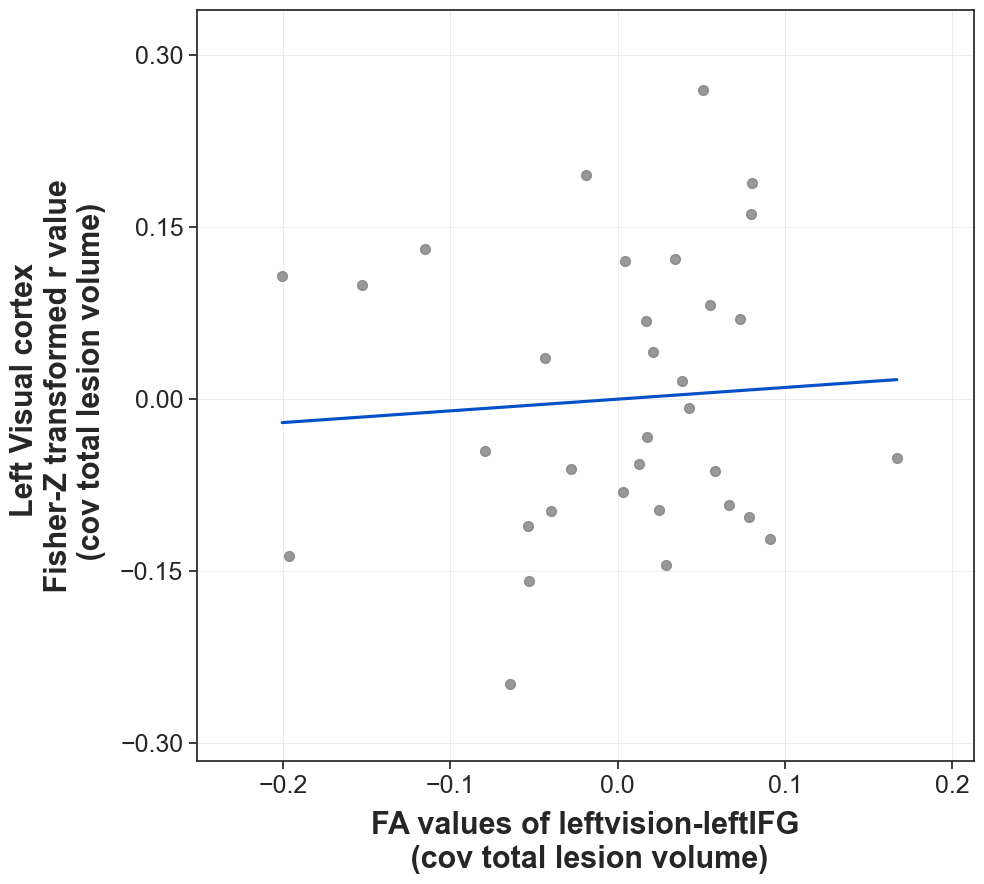

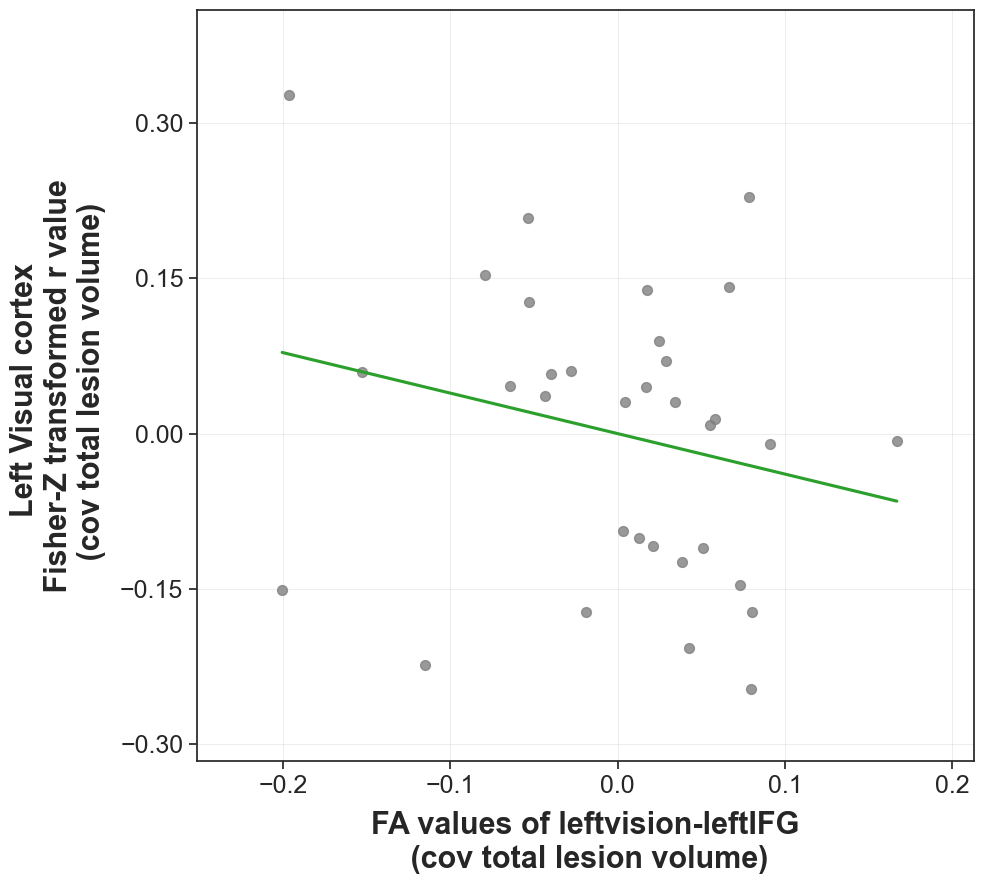

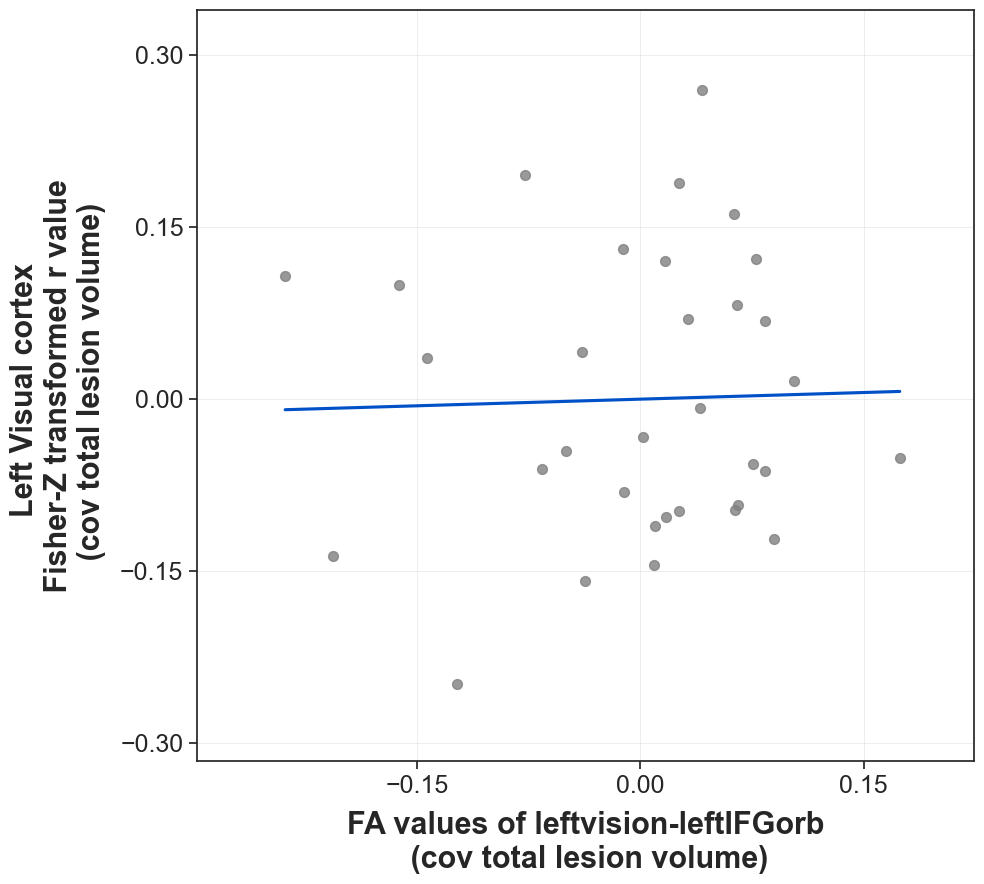

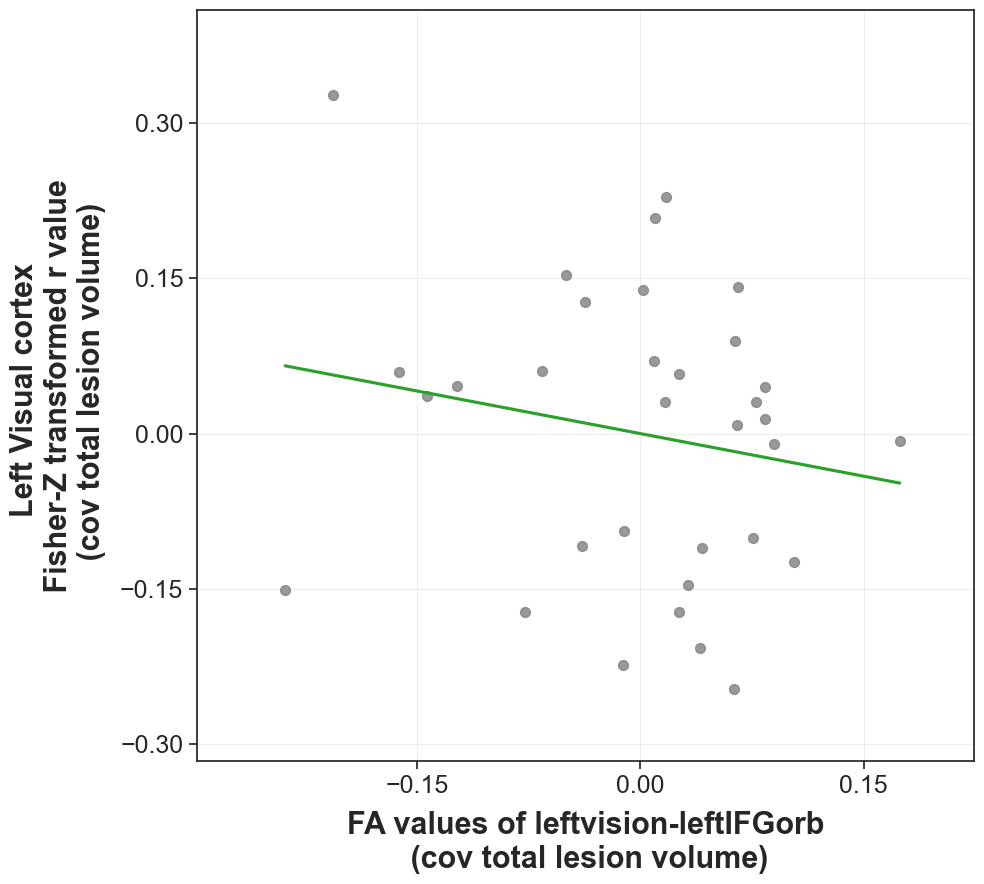

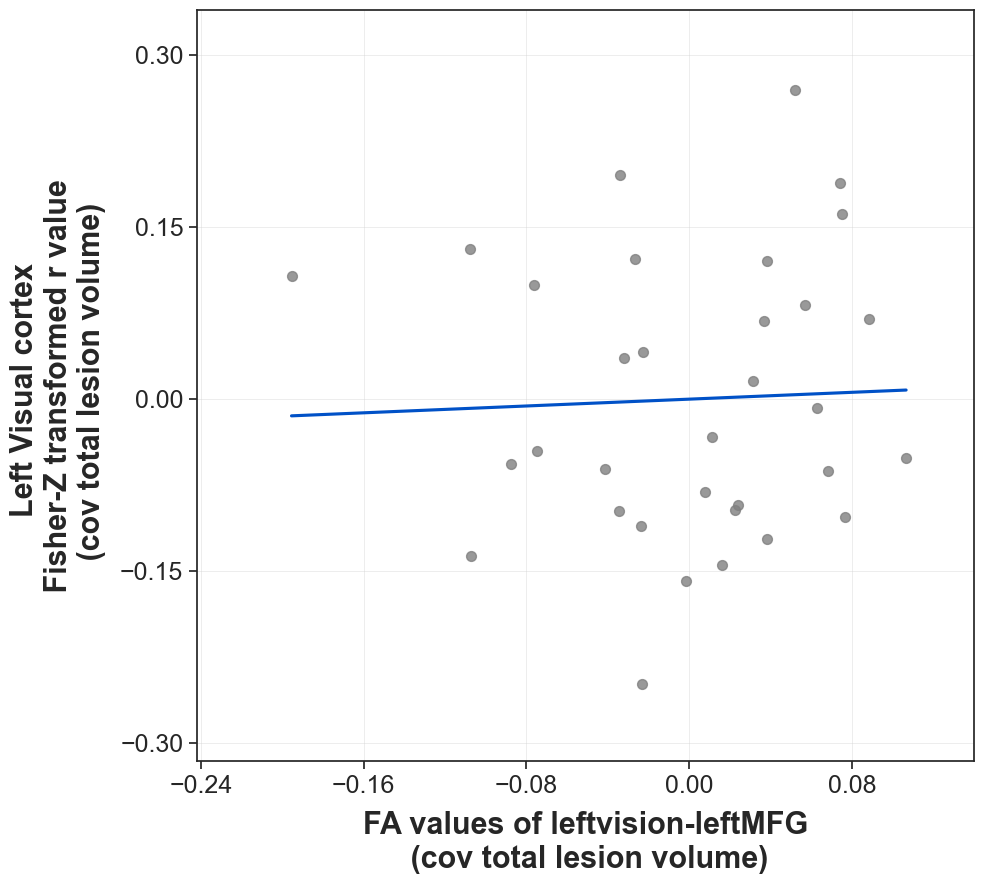

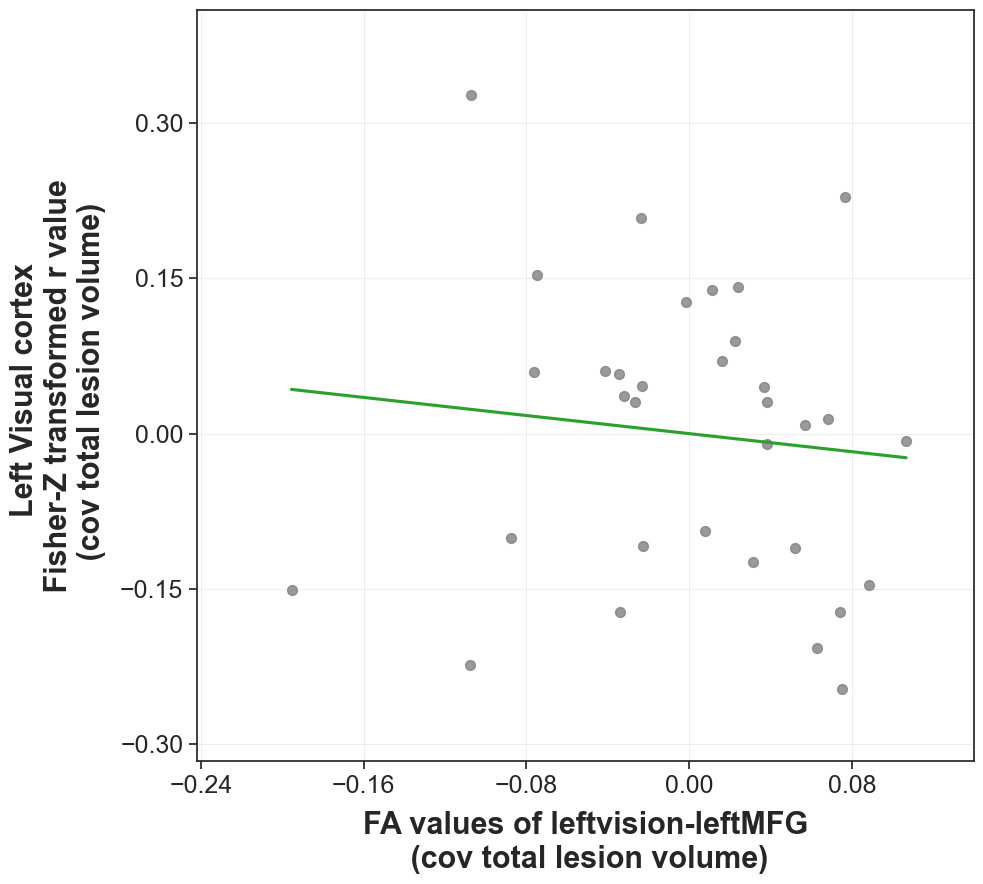

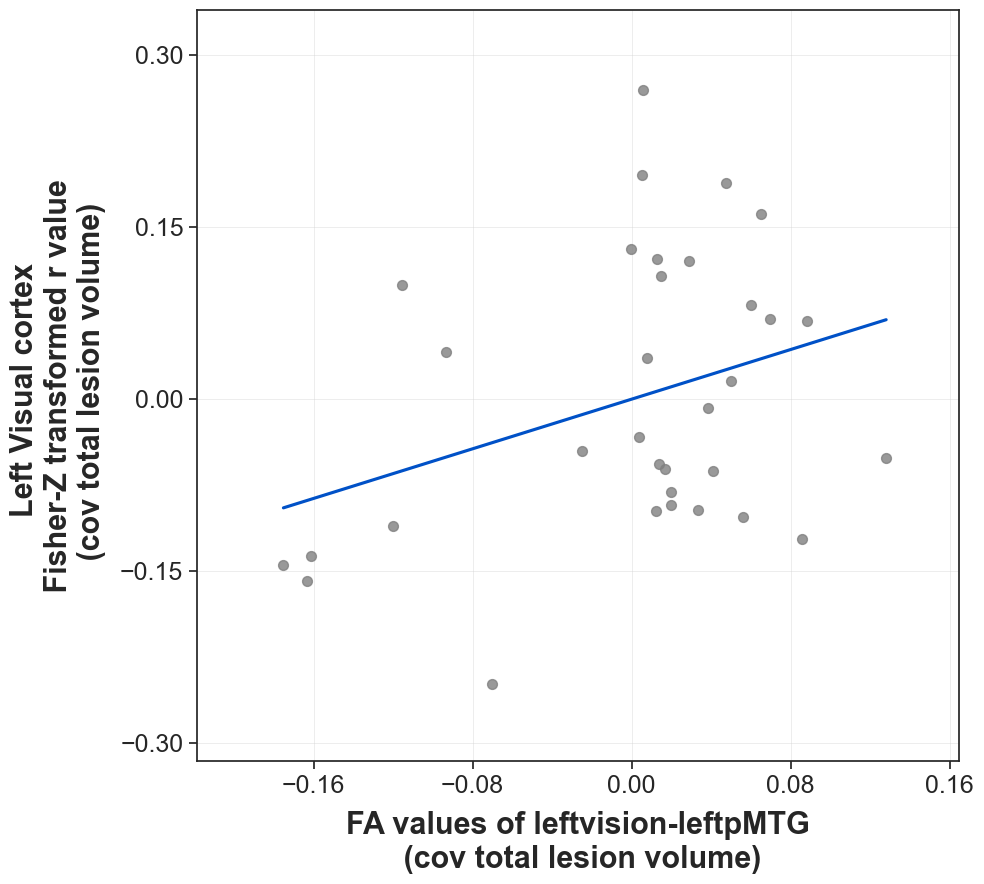

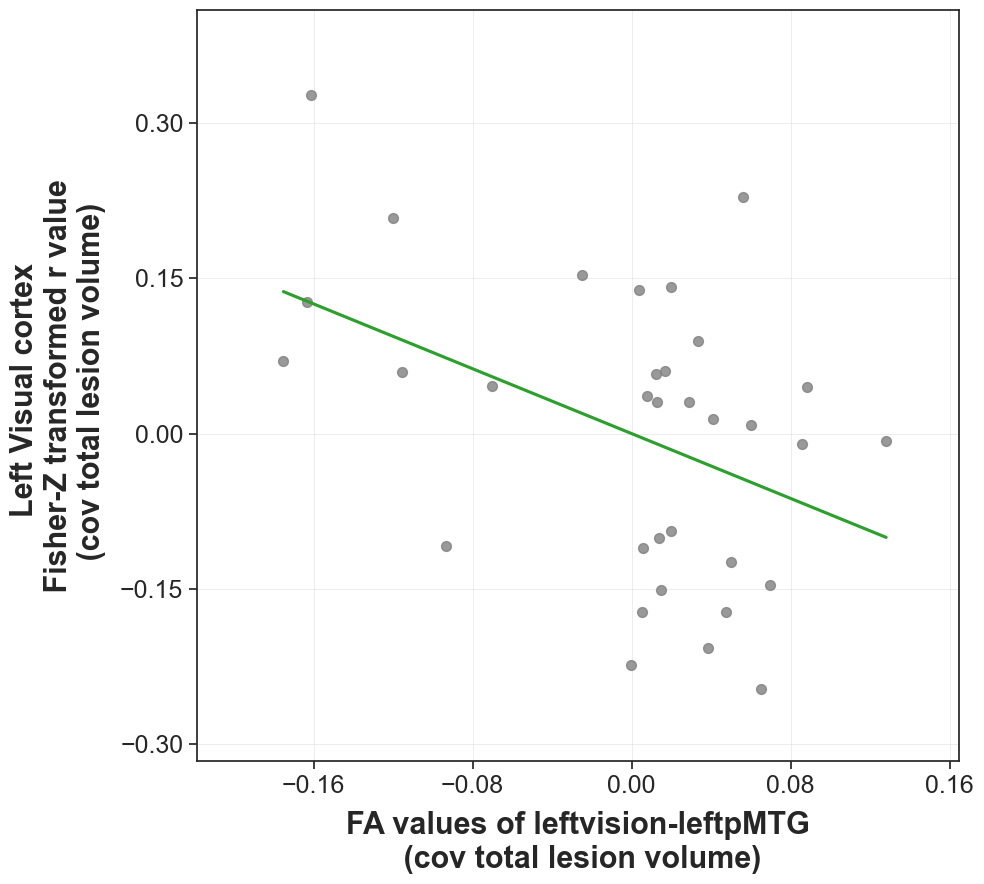

In [20]:
# 最终成图版
# 设置全局字体和图形风格
from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines


mpl.rcParams['font.family'] = 'Arial'

indicator = ['leftAG','leftATL','leftIFG','leftIFGorb','leftMFG','leftpMTG']



# CortexLabel = ['Left Visual Cortex']
roi_name = ['Left_WTPic_Harvord_visual_2mm_binary']

clip_fish = pd.read_csv(os.path.join(InputPath,'pcorrT_clip_res_uniquePool.csv'))
moco_fish = pd.read_csv(os.path.join(InputPath,'pcorrT_mocoPool_unique.csv'))

for r,roi in enumerate(roi_name):

    for idx,ind in enumerate(indicator):

        Interest_var = pat_wm[ind].reset_index(drop=True)
        cov_X = pd.concat([totalLV],axis=1)
        X = pd.concat([Interest_var,cov_X],axis=1)
        y_clip = clip_fish[clip_fish['roi_name']==roi]["fishZ_r"].reset_index(drop=True).rename('clip_fishZ_r')
        y_moco = moco_fish[moco_fish['roi_name']==roi]["fishZ_r"].reset_index(drop=True).rename('moco_fishZ_r')

        raw_data = pd.concat([X,y_clip,y_moco],axis=1)

        y_clip_resid = sm.OLS(y_clip, sm.add_constant(cov_X)).fit().resid
        y_moco_resid = sm.OLS(y_moco, sm.add_constant(cov_X)).fit().resid
        x_resid = sm.OLS(Interest_var, sm.add_constant(cov_X)).fit().resid

        plt.figure(figsize=(10,9))
        ax = sns.regplot(x=x_resid, y=y_clip_resid, scatter_kws={'s': 50, 'color': 'gray','marker':'o'}, line_kws={"color": "#0051C7"}, ci=None)
        corr_clip = pg.partial_corr(raw_data,x=ind, y='clip_fishZ_r', covar=['lesion_volume'], method='pearson',alternative='greater')
        # Get axis limits to place text in the upper right corner
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        line1 = mlines.Line2D([], [], color='#0051C7', marker='o', markersize=8, label=rf'CLIP (cov RN50 & MoCo) effect: $\rho={corr_clip["r"].values[0]:.2f}$, $p={corr_clip["p-val"].values[0]:.3f}$')
        # Label the axes
        plt.ylabel(f'Left Visual cortex \n Fisher-Z transformed r value \n (cov total lesion volume)', fontdict={'size': 22,'weight':'bold'},labelpad=10)
        plt.xlabel(f'FA values of leftvision-{ind}\n (cov total lesion volume)', fontdict={'size': 22,'weight':'bold'},labelpad=10)

        # Customize the grid
        plt.grid(True, which='both', color='lightgray', linestyle='-', linewidth=0.7,alpha=0.4)

        # Set limits for x and y axis for clarity
        plt.xlim(xlim[0] * 1.15, xlim[1] * 1.15)
        plt.ylim(ylim[0] * 1.15, ylim[1] * 1.15)
        plt.tick_params(axis='both',labelsize=18)

        plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=5))
        plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=5))
        # Show the plot
        plt.tight_layout()
        # plt.savefig(pjoin(r'C:\Users\39694\Desktop\Figure\Study2_lesion\RegressionModel\leftVis\Des_leftLang',roi +'_' +ind+'covTL.png'),dpi=600)
        # plt.close()


        plt.figure(figsize=(10,9))
        ax = sns.regplot(x=x_resid, y=y_moco_resid, scatter_kws={'s': 50, 'color': 'gray','marker':'^'}, line_kws={"color": "#2ca02c"}, ci=None)
        corr_moco = pg.partial_corr(raw_data,x=ind, y='moco_fishZ_r', covar=['lesion_volume'], method='pearson',alternative='less')
        # Get axis limits to place text in the upper right corner
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        line2 = mlines.Line2D([], [], color='#2ca02c', marker='o', markersize=8, label=rf'MoCo effect (cov CLIP & RN50): $\rho={corr_moco["r"].values[0]:.2f}$, $p={corr_moco["p-val"].values[0]:.3f}$')
        # Label the axes
        plt.ylabel(f'Left Visual cortex \n Fisher-Z transformed r value \n (cov total lesion volume)', fontdict={'size': 22,'weight':'bold'},labelpad=10)
        plt.xlabel(f'FA values of leftvision-{ind}\n (cov total lesion volume)', fontdict={'size': 22,'weight':'bold'},labelpad=10)
        # Customize the grid
        plt.grid(True, which='both', color='lightgray', linestyle='-', linewidth=0.7,alpha=0.4)
        # Set limits for x and y axis for clarity
        plt.xlim(xlim[0] * 1.15, xlim[1] * 1.15)
        plt.ylim(ylim[0] * 1.15, ylim[1] * 1.15)
        plt.tick_params(axis='both',labelsize=18)
        plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=5))
        plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=5))
        # Show the plot
        plt.tight_layout()
        # plt.savefig(pjoin(r'C:\Users\39694\Desktop\Figure\Study2_lesion\RegressionModel\leftVis\MoCo_leftLang',roi +'_' +ind+'covTL.png'),dpi=600)
        # plt.close()




